# Rating Distribution Analysis for Nautica (on Amazon)

In [25]:
#importing required packages
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
#intializing the options object to be fed into webdriver parameters
chrome_options=Options()
#chrome_options.add_argument("--headless")
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [27]:
# Add a custom User-Agent
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
chrome_options.add_argument(f'user-agent={user_agent}')

In [28]:
'''
Adding the property to not let program close the browser window post execution
This comes quite handy while visualizing how browser content are changing during 
execution and what was the last state of browser
'''
chrome_options.add_experimental_option("detach", True)

In [29]:
#starting the chrome driver
driver=webdriver.Chrome(options=chrome_options)

In [30]:
#setting up the target website ot be scrapped
target='https://www.amazon.com/s?k=nautica+clothing&crid=9FGH9U5S5KBF&sprefix=nautica+clothing%2Caps%2C165&ref=nb_sb_noss_1'

In [31]:
#getting the web page
driver.get(target)
#waiting for the page to load
time.sleep(random.uniform(2, 10))
#maximizing the browser window
driver.maximize_window()

In [32]:
# Store product data
product_data = {
    "Product Name": [],
    "Price": [],
    "Rating": [],
    "Review Count": []
}

In [33]:
page_number=1
while page_number<7:
    #selecting a product block
    products = driver.find_elements(By.XPATH, '//div[contains(@class, "s-main-slot")]/div[@data-component-type="s-search-result"]')

    # Iterate over the products and extract details
    for product in products:

        try:
            product_name = product.find_element(By.XPATH, './/h2[@class="a-size-mini s-line-clamp-1"]').text
        except NoSuchElementException:
            continue
        
        if 'Nautica' in product_name:
            try:
                # Product Name
                product_name = product.find_element(By.XPATH,'.//span[@class="a-size-base-plus a-color-base a-text-normal"]').text
            except:
                product_name = 'N/A'

            try:
                # Price
                price = product.find_element(By.XPATH, './/span[@class="a-price-whole"]').text
                price_fraction = product.find_element(By.XPATH, './/span[@class="a-price-fraction"]').text
                full_price = f"{price}.{price_fraction}"
            except:
                full_price = 'N/A'

            try:
                # Rating
                rating = product.find_element(By.XPATH, './/span[@class="a-icon-alt"]').get_attribute('innerHTML').split()[0]
            except:
                rating = 'N/A'

            try:
                # Review Count
                review_count = product.find_element(By.XPATH, './/span[@class="a-size-base s-underline-text"]').text
            except:
                review_count = 'N/A'

            # Store the product details in the dictionary
            product_data["Product Name"].append(product_name)
            product_data["Price"].append(full_price)
            product_data["Rating"].append(rating)
            product_data["Review Count"].append(review_count)
        else:
            pass
    
    try:
        #incrementing the page number
        page_number+=1
        #wait till the next button appears and then locate it
        button = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, '//a[contains(@class, "s-pagination-next")]'))
        )
        # Click the "Next" button
        button.click()
        
        #waiting for the page to load
        time.sleep(10)
    except:
        print(page_number)
        print("No 'Next' button found. Ending the loop.")
        break


In [34]:
df = pd.DataFrame(product_data)

In [35]:
df.shape

(227, 4)

In [36]:
df['Rating'].value_counts()

4.5    37
4.6    36
4.4    32
4.3    18
5.0    16
4.7    15
4.2    14
N/A    13
4.0    12
4.1     8
3.8     6
4.8     5
3.9     5
3.5     4
3.7     2
3.4     2
3.3     1
1.0     1
Name: Rating, dtype: int64

In [37]:
df['Review Count'].value_counts()

N/A      13
3         8
1         6
5         5
2         5
         ..
397       1
388       1
1,182     1
97        1
53        1
Name: Review Count, Length: 153, dtype: int64

In [38]:
# Replace 'N/A' strings with NaN
df['Rating'].replace('N/A', np.nan, inplace=True)
df['Review Count'].replace('N/A', np.nan, inplace=True)

# Convert 'Rating' and 'Review Count' columns to numeric, forcing non-numeric values to NaN
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Review Count'] = pd.to_numeric(df['Review Count'], errors='coerce')

# Fill missing values in the 'Rating' column with the average (mean) of the ratings
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

# Fill missing values in the 'Review Count' column with the median of the review counts
df['Review Count'].fillna(df['Review Count'].median(), inplace=True)

In [39]:
df['Rating'].value_counts()

4.500000    37
4.600000    36
4.400000    32
4.300000    18
5.000000    16
4.700000    15
4.200000    14
4.388785    13
4.000000    12
4.100000     8
3.800000     6
4.800000     5
3.900000     5
3.500000     4
3.700000     2
3.400000     2
3.300000     1
1.000000     1
Name: Rating, dtype: int64

In [40]:
df['Review Count'].value_counts()

46.0     49
3.0       8
1.0       6
2.0       5
4.0       5
         ..
381.0     1
403.0     1
263.0     1
88.0      1
53.0      1
Name: Review Count, Length: 119, dtype: int64

In [41]:
df.dtypes

Product Name     object
Price            object
Rating          float64
Review Count    float64
dtype: object

In [42]:
df.head(100)

,Product Name,Price,Rating,Review Count
0,Men's Competition Sustainably Crafted Printed ...,21.50,4.0,17.0
1,Women's Easy Comfort Scoop Neck Supersoft 100%...,12.74,4.1,46.0
2,Men's Slim Fit Short Sleeve Solid Polo Shirt,38.06,4.4,789.0
3,Men's Short Sleeve 100% Cotton Nautical Series...,15.21,4.5,46.0
4,Men's J-Class Logo Long Sleeve T-Shirt,22.99,4.3,591.0
...,...,...,...,...
95,Junior's Uniform Stretch Bermuda Short,10.50,4.2,811.0
96,Women's Stripe Wide Leg Pants,60.93,4.3,14.0
97,Men's Standard Quick Dry Classic Logo Tri-Bloc...,24.32,4.6,46.0
98,Young Men's Active Short Sleeve Performance T-...,13.51,4.3,311.0


## Plot for Top 10 Most Popular Items based on Review Count

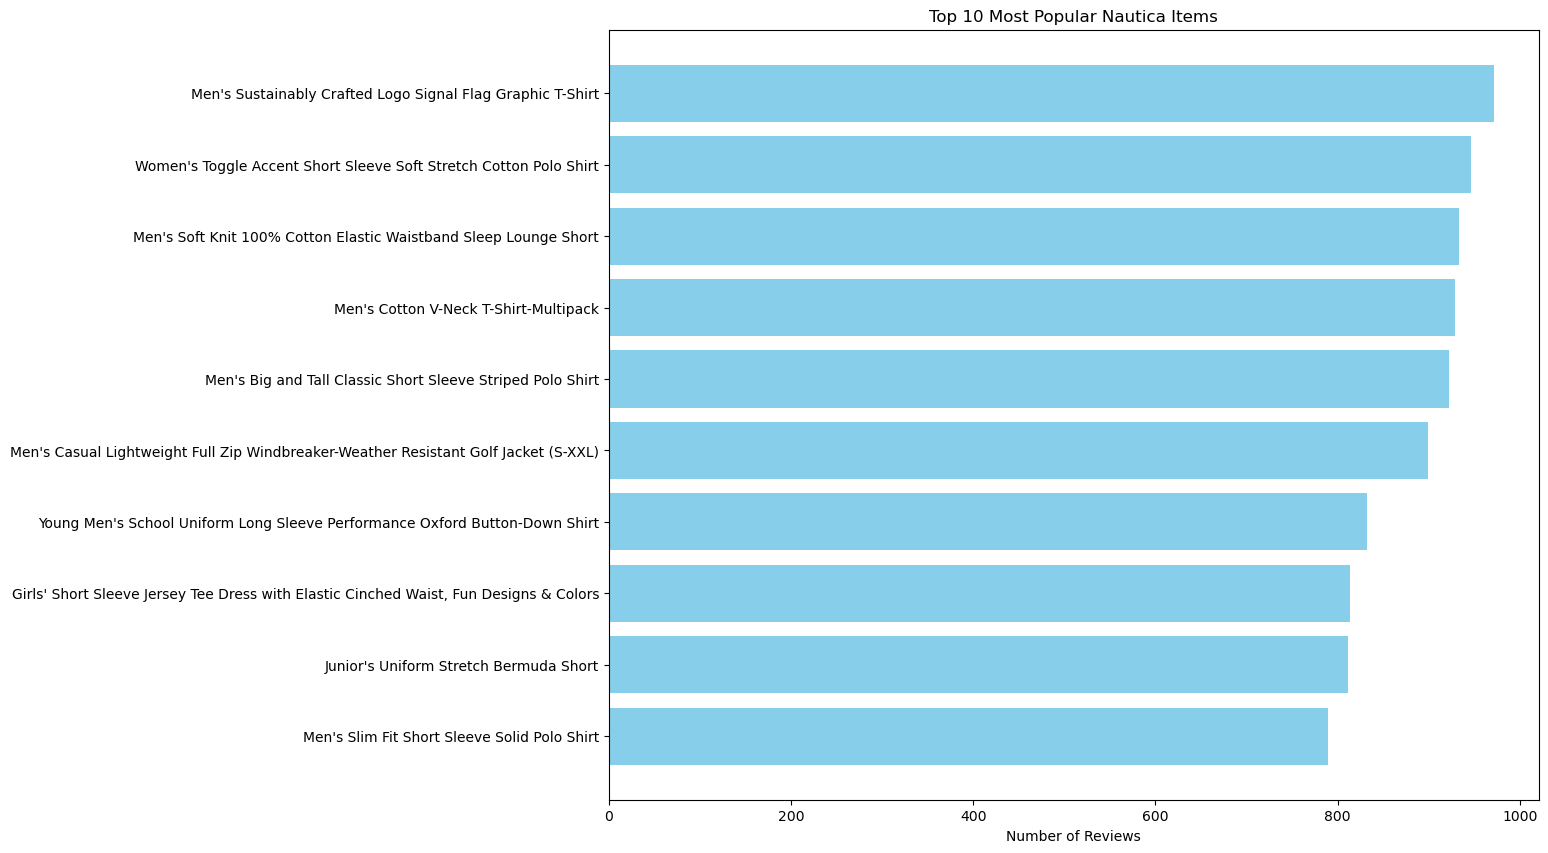

In [43]:
#visualization 1
#filtering by top review counts
top_popular_items = df.nlargest(10, 'Review Count')

plt.figure(figsize=(12, 10))
plt.barh(top_popular_items['Product Name'], top_popular_items['Review Count'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.title('Top 10 Most Popular Nautica Items')
plt.gca().invert_yaxis()  # Invert y-axis to show the most popular items on top
plt.show()

##  Distribution of Ratings

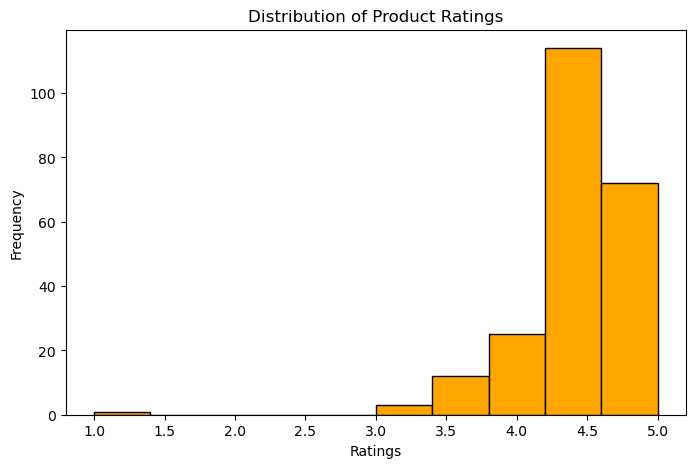

In [44]:
#visualization 2
plt.figure(figsize=(8, 5))
plt.hist(df['Rating'].dropna(), bins=10, color='orange', edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Product Ratings')
plt.show()

## Items with Lowest Ratings (Badly Reviewed)

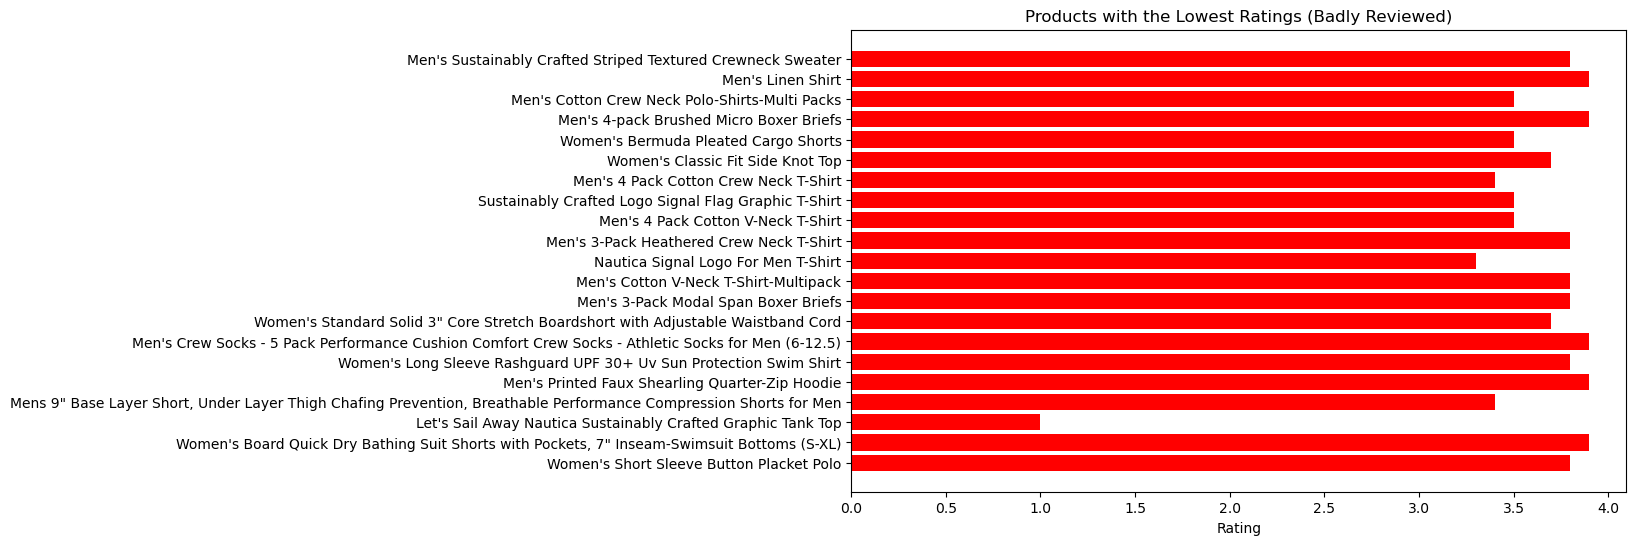

In [45]:
#visualization 3
# Assuming items with ratings below 4.0 are considered badly reviewed
badly_reviewed_items = df[df['Rating'] < 4.0]

plt.figure(figsize=(10, 6))
plt.barh(badly_reviewed_items['Product Name'], badly_reviewed_items['Rating'], color='red')
plt.xlabel('Rating')
plt.title('Products with the Lowest Ratings (Badly Reviewed)')
plt.gca().invert_yaxis()  # Invert y-axis to show the lowest ratings on top
plt.show()

## Elasticity Analysis (Review Count v/s Price, Ratings & Price v/s Ratings)

In [46]:
df.dtypes

Product Name     object
Price            object
Rating          float64
Review Count    float64
dtype: object

In [47]:
#changing the datatype of Price to float
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Data Cleaning - drop rows with missing values in relevant columns
df = df.dropna(subset=['Price', 'Review Count', 'Rating'])

#Log transformation for elasticity analysis
df['log_price'] = np.log(df['Price'])
df['log_review_count'] = np.log(df['Review Count'] + 1)  # Adding 1 to avoid log(0)
df['log_ratings'] = np.log(df['Rating'] + 1) # Adding 1 to avoid log(0)

In [48]:
df.head()

,Product Name,Price,Rating,Review Count,log_price,log_review_count,log_ratings
0,Men's Competition Sustainably Crafted Printed ...,21.50,4.0,17.0,3.068053,2.890372,1.609438
1,Women's Easy Comfort Scoop Neck Supersoft 100%...,12.74,4.1,46.0,2.544747,3.850148,1.629241
2,Men's Slim Fit Short Sleeve Solid Polo Shirt,38.06,4.4,789.0,3.639164,6.672033,1.686399
3,Men's Short Sleeve 100% Cotton Nautical Series...,15.21,4.5,46.0,2.721953,3.850148,1.704748
4,Men's J-Class Logo Long Sleeve T-Shirt,22.99,4.3,591.0,3.135059,6.383507,1.667707


In [49]:
#checking is any column is having NA values before feeding the data into a regression model
print(df[['log_review_count', 'log_ratings', 'log_price']].isna().sum())

log_review_count    0
log_ratings         0
log_price           0
dtype: int64


In [50]:
#Regression Model 1 - Review Count vs. Price and Ratings
X1 = df[['log_price', 'log_ratings']]
y1 = df['log_review_count']

# Add constant (intercept) to the model
X1 = sm.add_constant(X1)

# Fit the regression model
model1 = sm.OLS(y1, X1).fit()

# Print the summary of the regression model
print("Model 1: Review Count vs Price and Ratings")
print(model1.summary())

Model 1: Review Count vs Price and Ratings
                            OLS Regression Results                            
Dep. Variable:       log_review_count   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     9.271
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           0.000137
Time:                        04:00:37   Log-Likelihood:                -414.20
No. Observations:                 221   AIC:                             834.4
Df Residuals:                     218   BIC:                             844.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const  

### Insights from the Regression Analysis for Nautica

This regression model analyzes the relationship between `log_review_count` (dependent variable) and two independent variables: `log_price` and `log_ratings`. Here’s a detailed breakdown of the results:

#### 1. **Coefficients and Elasticity:**
   - **`log_price` Coefficient:** -1.0859
     - This coefficient implies that a 1% increase in the price is associated with an approximate 1.0859% decrease in the review count. This indicates a negative elasticity between price and review count.
     - The p-value for `log_price` is 0.000, which is well below the 0.05 threshold, indicating that this relationship is statistically significant.
   - **`log_ratings` Coefficient:** 1.5005
     - This coefficient suggests that a 1% increase in ratings is associated with an approximate 1.5005% increase in the review count. This indicates a positive elasticity between ratings and review count.
     - However, the p-value for `log_ratings` is 0.207, which is greater than 0.05. This means that the relationship between `log_ratings` and `log_review_count` is **not statistically significant** at the 5% significance level.
   - **Constant:** 4.7654
     - The constant (intercept) represents the baseline value of `log_review_count` when both `log_price` and `log_ratings` are zero.

#### 2. **Statistical Significance:**
   - **`log_price`:** The coefficient for `log_price` is statistically significant (p-value = 0.000). This means there is strong evidence to suggest that price negatively impacts the number of reviews.
   - **`log_ratings`:** The coefficient for `log_ratings` is not statistically significant (p-value = 0.207), indicating that ratings do not have a strong, reliable impact on review count based on this model.

#### 3. **Model Fit:**
   - **R-squared:** 0.078
     - This value indicates that only 7.8% of the variance in `log_review_count` is explained by `log_price` and `log_ratings`. This is relatively low, suggesting that other factors not included in the model might explain the variation in review counts.
   - **Adjusted R-squared:** 0.070
     - Similar to the R-squared, this adjusted value accounts for the number of predictors in the model and suggests that the model's explanatory power remains weak.

#### 4. **F-statistic and Model Significance:**
   - **F-statistic:** 9.271 with a p-value of 0.000137
     - This low p-value indicates that the model as a whole is statistically significant, meaning that at least one of the predictors (`log_price` or `log_ratings`) significantly affects `log_review_count`.

#### 5. **Residual Analysis and Model Diagnostics:**
   - **Omnibus:** 8.133 and **Prob(Omnibus):** 0.017
     - The Omnibus test suggests some deviation from normality in the residuals, which could indicate that the assumptions of linear regression might not be fully met.
   - **Durbin-Watson:** 1.754
     - This value is close to 2, indicating that there is likely no strong autocorrelation in the residuals.
   - **Jarque-Bera (JB):** 4.062 with a p-value of 0.131
     - This test further indicates that the residuals are approximately normally distributed, as the p-value is greater than 0.05.

### Conclusion:
- **Price Elasticity:** The model indicates a strong, statistically significant negative relationship between `log_price` and `log_review_count`. As the price increases, the review count tends to decrease.
- **Ratings Impact:** Although the coefficient for `log_ratings` is positive, suggesting a potential positive relationship with review count, the high p-value (0.207) indicates that this relationship is not statistically significant.
- **Model Limitations:** The low R-squared value (0.078) suggests that the model does not explain much of the variation in the review count, indicating that other factors not included in this model may influence the review count.
- **Recommendation:** To improve the model's explanatory power, consider including additional variables that might affect review count, such as product quality, brand reputation, or promotional activities. Further, check the model assumptions (e.g., linearity, homoscedasticity) to ensure validity.

In [51]:
#Regression Model 2 - Price vs. Ratings only
X2 = df[['log_ratings']]
y2 = df['log_price']

# Add constant (intercept) to the model
X2 = sm.add_constant(X2)

# Fit the regression model
model2 = sm.OLS(y2, X2).fit()

# Print the summary of the regression model
print("Model 2: Price vs Ratings")
print(model2.summary())

Model 2: Price vs Ratings
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.018
Date:                Tue, 01 Oct 2024   Prob (F-statistic):             0.0838
Time:                        04:00:42   Log-Likelihood:                -136.91
No. Observations:                 221   AIC:                             277.8
Df Residuals:                     219   BIC:                             284.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.2695  

### Insights from the Regression Analysis for Elasticity

In this regression analysis, the model examines the relationship between `log_price` (dependent variable) and `log_ratings` (independent variable). The analysis aims to understand how changes in product ratings affect the price in percentage terms.

#### 1. **Coefficients and Elasticity:**
   - **`log_ratings` Coefficient:** 0.5817
     - This coefficient suggests that a 1% increase in the product's ratings (`log_ratings`) is associated with an approximate 0.5817% increase in the price (`log_price`). In elasticity terms, this indicates a moderate positive elasticity between ratings and price.
     - The p-value for `log_ratings` is 0.084, which is slightly above the conventional 0.05 significance level but close to the 0.1 level. This means the relationship is borderline statistically significant, but we should interpret this result with caution.

#### 2. **Statistical Significance:**
   - **`log_ratings`:** The p-value of 0.084 suggests that there is some evidence to support the relationship between ratings and price, though it is not strong enough to be considered statistically significant at the 5% level. However, it could be considered significant at the 10% level.
   - **Constant:** The constant term has a coefficient of 2.2695 and a p-value of 0.000, indicating that it is statistically significant. This represents the baseline log-transformed price when `log_ratings` is zero.

#### 3. **Model Fit:**
   - **R-squared:** 0.014
     - This indicates that only 1.4% of the variability in `log_price` is explained by the `log_ratings`. This is very low, suggesting that the model does not capture most of the factors that influence the price.
   - **Adjusted R-squared:** 0.009
     - This adjusted value, accounting for the number of predictors in the model, further confirms the poor explanatory power of the model.

#### 4. **F-statistic and Model Significance:**
   - **F-statistic:** 3.018 with a p-value of 0.0838
     - The F-statistic p-value is slightly above 0.05, indicating that the model as a whole is not statistically significant at the 5% level but is close to being significant at the 10% level. This borderline significance suggests that `log_ratings` may have some influence on price, but other factors not included in the model likely play a more substantial role.

#### 5. **Residual Analysis and Model Diagnostics:**
   - **Omnibus:** 29.596 and **Prob(Omnibus):** 0.000
     - The Omnibus test indicates that the residuals deviate from normality. This deviation might suggest some violation of the linear regression assumptions.
   - **Durbin-Watson:** 1.953
     - The Durbin-Watson value is close to 2, indicating that there is likely no significant autocorrelation in the residuals.
   - **Jarque-Bera (JB):** 10.544 with a p-value of 0.005
     - This test result, with a low p-value, indicates that the residuals are not perfectly normally distributed.

#### 6. **Confidence Interval for `log_ratings`:**
   - The 95% confidence interval for the `log_ratings` coefficient ranges from -0.078 to 1.242. This interval includes zero, reinforcing the fact that the relationship between ratings and price may not be reliably estimated with this model.

### Conclusion:
- **Price Elasticity with Respect to Ratings:** The coefficient of `log_ratings` (0.5817) indicates a positive elasticity, suggesting that higher ratings might be associated with higher prices. However, the borderline statistical significance (p-value = 0.084) and low R-squared value indicate that this relationship is weak and not fully reliable.
- **Model Fit:** The very low R-squared value (0.014) suggests that other factors not included in this model have a much more significant impact on price. The model has limited explanatory power.
- **Model Limitations:** The diagnostic tests (Omnibus and Jarque-Bera) indicate some potential violations of regression assumptions, suggesting that further exploration or alternative modeling approaches might be necessary.

### Recommendations:
- Consider including additional variables that might affect the price, such as product category, brand reputation, or promotional strategies, to improve the model's explanatory power.
- Explore non-linear or more complex models, as the current simple linear relationship between ratings and price might not capture the nuances of the data.

In [50]:
driver.close

<bound method WebDriver.close of <selenium.webdriver.chrome.webdriver.WebDriver (session="3a3a988cad61278a13b98070c061176e")>>